# Hybrid BERT-XGBoost Model for Fake News Detection

This notebook implements a hybrid deep learning approach for fake news classification using fine-tuned DistilBERT embeddings combined with XGBoost classification. The methodology includes explainable AI (XAI) analysis using SHAP values to provide model interpretability.

## Dependencies Installation

The following libraries are required for this implementation:
- Transformers: For BERT-based model fine-tuning
- XGBoost: For gradient boosting classification
- Datasets: For efficient data handling
- Scikit-learn: For evaluation metrics and data splitting
- SHAP: For model interpretability and explainability analysis


In [ ]:
!pip install transformers[torch] --quiet
!pip install xgboost --quiet
!pip install datasets --quiet
!pip install accelerate -U --quiet
!pip install scikit-learn --quiet
!pip install shap --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 59.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed

## Library Imports and Configuration

Import necessary libraries and configure the environment for reproducibility. This includes setting random seeds, configuring device settings for GPU acceleration, and establishing global plotting styles for consistent figure presentation.


In [ ]:
import pandas as pd
import numpy as np
import torch
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertModel, Trainer, TrainingArguments
from datasets import Dataset
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.titlesize': 16
})

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-11-11 15:34:14.219937: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762875254.418753      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762875254.473574      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


## Data Loading and Preprocessing

Load the WELFake dataset and perform initial data cleaning. The dataset is split into training and test sets with stratification to maintain class distribution. The title and text fields are combined to create a richer context for the model.


In [ ]:
df = pd.read_csv('/kaggle/input/fake-news-classification/WELFake_Dataset.csv')

if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

df = df.dropna().reset_index(drop=True)
df['full_text'] = df['title'] + ' [SEP] ' + df['text']

df_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=SEED,
    stratify=df['label']
)

print(f"Full dataset size after cleaning: {len(df)}")
print(f"Training set size for fine-tuning: {len(df_train)}")
print(f"Held-out test set size for final evaluation: {len(df_test)}")

Full dataset size after cleaning: 71537
Training set size for fine-tuning: 57229
Held-out test set size for final evaluation: 14308


## Tokenization

Convert the text data into tokenized format suitable for BERT-based models. The DistilBERT tokenizer is used to process the combined text with a maximum sequence length of 512 tokens. The datasets are formatted for PyTorch compatibility.


In [ ]:
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples['full_text'], padding='max_length', truncation=True, max_length=512)

tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

tokenized_train_dataset = tokenized_train_dataset.rename_column("label", "labels")
tokenized_train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

tokenized_test_dataset = tokenized_test_dataset.rename_column("label", "labels")
tokenized_test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

print("\nData prepared for fine-tuning.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/57229 [00:00<?, ? examples/s]

Map:   0%|          | 0/14308 [00:00<?, ? examples/s]


Data prepared for fine-tuning.


## Fine-Tuning DistilBERT

Fine-tune the DistilBERT model on the training dataset for sequence classification. Early stopping is implemented to prevent overfitting by monitoring validation loss. The best model checkpoint is saved based on validation performance.


In [ ]:
from transformers import EarlyStoppingCallback

model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {'accuracy': accuracy_score(labels, predictions)}

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
)

print("Starting DistilBERT fine-tuning with early stopping...")
trainer.train()
print("Fine-tuning complete!")

FINETUNED_MODEL_PATH = "./finetuned_distilbert"
trainer.save_model(FINETUNED_MODEL_PATH)
tokenizer.save_pretrained(FINETUNED_MODEL_PATH)
print(f"Best fine-tuned model saved to {FINETUNED_MODEL_PATH}")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting DistilBERT fine-tuning with early stopping...


Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.026600,0.024429,0.993640
2,0.022100,0.012031,0.996575
3,0.004900,0.012018,0.997204
4,0.004300,0.036443,0.992452


Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.


Fine-tuning complete!
Best fine-tuned model saved to ./finetuned_distilbert


## Embedding Extraction

Extract contextual embeddings from the fine-tuned DistilBERT model. The [CLS] token embeddings are used as feature representations for each news article. These embeddings capture semantic and contextual information learned during fine-tuning.


In [ ]:
finetuned_bert_model = DistilBertModel.from_pretrained(FINETUNED_MODEL_PATH)
finetuned_bert_model.to(device)

class NewsDatasetForEmbedding(TorchDataset):
    def __init__(self, texts, tokenizer, max_len=512):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item_idx):
        text = str(self.texts[item_idx])
        encoding = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_len,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

def get_bert_embeddings(data_loader, model, device):
    model.eval()
    all_embeddings = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Extracting Fine-Tuned Embeddings"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.extend(cls_embeddings)
    return np.array(all_embeddings)

full_text_dataset = NewsDatasetForEmbedding(
    texts=df['full_text'].to_numpy(),
    tokenizer=tokenizer
)
full_data_loader = DataLoader(full_text_dataset, batch_size=32)

X_finetuned = get_bert_embeddings(full_data_loader, finetuned_bert_model, device)
y = df['label'].to_numpy()

print("Embedding extraction with fine-tuned model complete.")
print(f"Shape of new features (embeddings): {X_finetuned.shape}")
print(f"Shape of labels: {y.shape}")

Extracting Fine-Tuned Embeddings: 100%|██████████| 2236/2236 [32:33<00:00,  1.14it/s]


Embedding extraction with fine-tuned model complete.
Shape of new features (embeddings): (71537, 768)
Shape of labels: (71537,)


## XGBoost Classification

Train an XGBoost classifier on the extracted BERT embeddings. The embeddings serve as high-dimensional feature vectors, and XGBoost learns non-linear decision boundaries for binary classification. The same train-test split is maintained for consistency.


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_finetuned, 
    y, 
    test_size=0.2, 
    random_state=SEED,
    stratify=y
)

print(f"Training data shape for XGBoost: {X_train.shape}")
print(f"Testing data shape for XGBoost: {X_test.shape}")

xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    seed=SEED
)

print("\nTraining XGBoost model on fine-tuned embeddings...")
xgb_classifier.fit(X_train, y_train)
print("XGBoost training complete.")

Training data shape for XGBoost: (57229, 768)
Testing data shape for XGBoost: (14308, 768)

Training XGBoost model on fine-tuned embeddings...
XGBoost training complete.


## SHAP Analysis for Model Interpretability

Perform explainable AI analysis using SHAP (SHapley Additive exPlanations) values. This provides both global feature importance and instance-level explanations, demonstrating which embedding dimensions contribute most to the model's predictions.


--- Starting SHAP Analysis for Model Interpretability ---
\n--- Generating SHAP Summary Plot ---


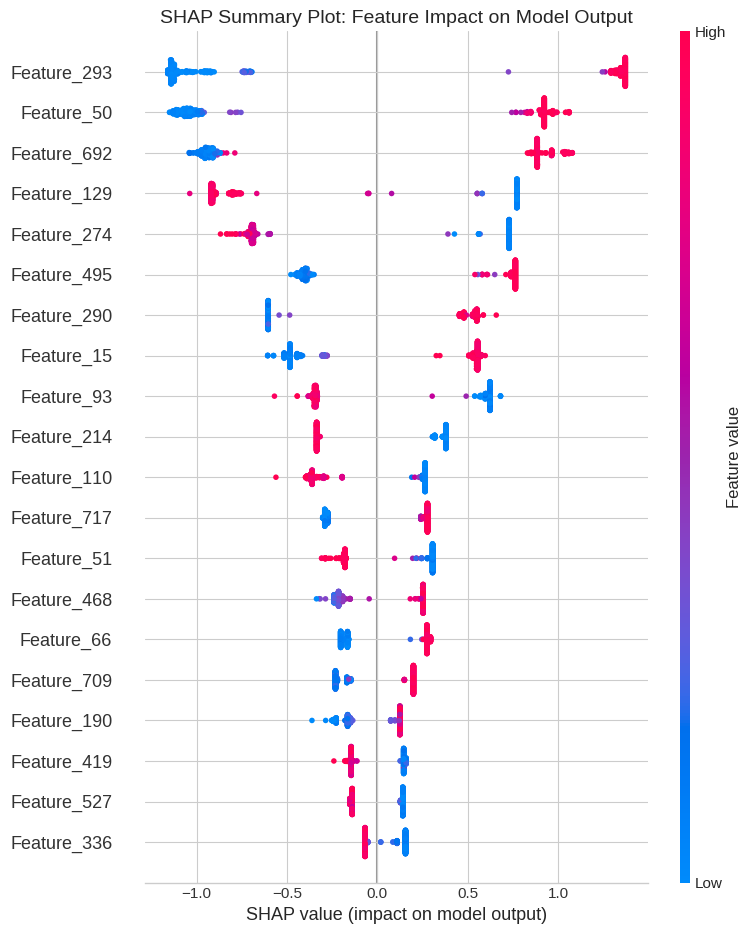

\n--- Generating SHAP Force Plot for a 'Fake' News Example ---
This plot shows features pushing the prediction higher (towards 'Fake', in red) and lower (towards 'Real', in blue).


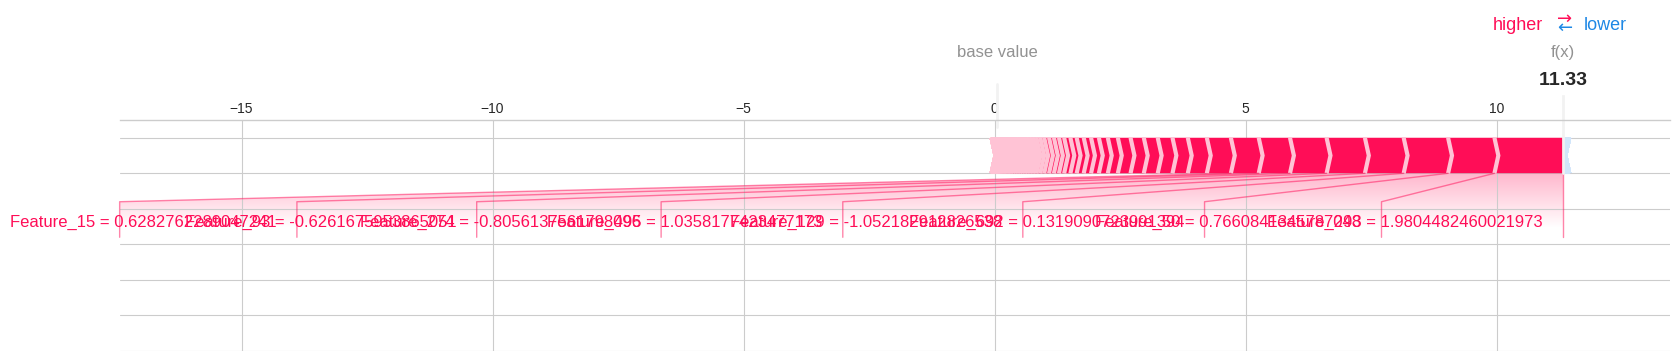

In [ ]:
print("--- Starting SHAP Analysis for Model Interpretability ---")

explainer = shap.TreeExplainer(xgb_classifier)

X_test_sample = shap.sample(X_test, 500)
shap_values = explainer.shap_values(X_test_sample)

print("\\n--- Generating SHAP Summary Plot ---")
plt.title("SHAP Summary Plot: Feature Impact on Model Output")
shap.summary_plot(shap_values, X_test_sample, feature_names=[f'Feature_{i}' for i in range(X_test.shape[1])], max_display=20, show=False)
plt.savefig("shap_summary_plot.png", bbox_inches='tight')
plt.show()

print("\\n--- Generating SHAP Force Plot for a 'Fake' News Example ---")
fake_article_index = np.where(y_test == 1)[0][0]
base_value = explainer.expected_value

print("This plot shows features pushing the prediction higher (towards 'Fake', in red) and lower (towards 'Real', in blue).")

shap.force_plot(
    base_value, 
    shap_values[fake_article_index,:], 
    X_test_sample[fake_article_index,:], 
    feature_names=[f'Feature_{i}' for i in range(X_test.shape[1])],
    matplotlib=True,
    show=False
)
plt.savefig("shap_force_plot.png", bbox_inches='tight')
plt.show()

## Model Evaluation

Evaluate the hybrid BERT-XGBoost model on the held-out test set. Performance metrics include accuracy, precision, recall, F1-score, and confusion matrix visualization. This provides a comprehensive assessment of the model's classification capabilities.


\n--- Final Model Performance ---
Accuracy: 99.76%\n
Classification Report:
              precision    recall  f1-score   support

    Real (0)       1.00      1.00      1.00      7006
    Fake (1)       1.00      1.00      1.00      7302

    accuracy                           1.00     14308
   macro avg       1.00      1.00      1.00     14308
weighted avg       1.00      1.00      1.00     14308

\nConfusion Matrix:
[[6990   16]
 [  19 7283]]


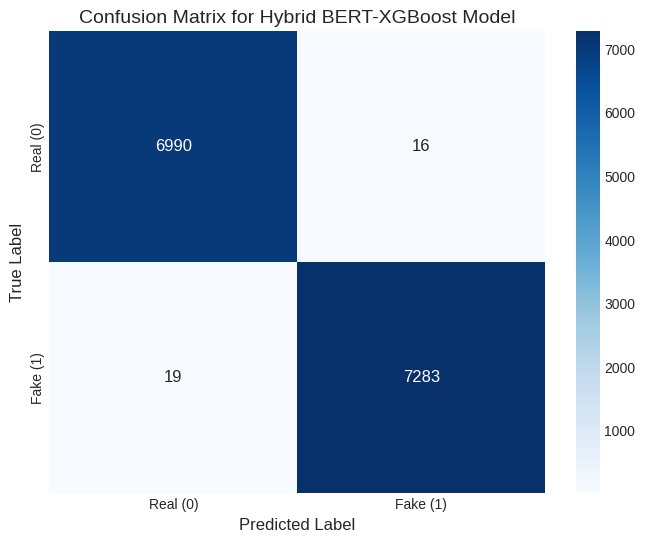

In [ ]:
y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"\\n--- Final Model Performance ---")
print(f"Accuracy: {accuracy * 100:.2f}%\\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)']))

print("\\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real (0)', 'Fake (1)'], yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Hybrid BERT-XGBoost Model')
plt.show()

## Detailed Performance Metrics

Generate a comprehensive performance report with detailed metrics for each class. This includes per-class precision, recall, and F1-scores, along with macro-averaged metrics for overall model assessment.


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import numpy as np

print("--- Final Model Performance (Detailed) ---")
print(f"Overall Accuracy: {accuracy_score(y_test, y_pred) * 100:.4f}%\n")

precision_real = precision_score(y_test, y_pred, pos_label=0)
recall_real = recall_score(y_test, y_pred, pos_label=0)
f1_real = f1_score(y_test, y_pred, pos_label=0)

precision_fake = precision_score(y_test, y_pred, pos_label=1)
recall_fake = recall_score(y_test, y_pred, pos_label=1)
f1_fake = f1_score(y_test, y_pred, pos_label=1)

macro_precision = (precision_real + precision_fake) / 2
macro_recall = (recall_real + recall_fake) / 2
macro_f1 = (f1_real + f1_fake) / 2

print("Classification Report:")
print("              precision    recall  f1-score   support")
print(f"    Real (0)    {precision_real:10.4f}  {recall_real:8.4f}  {f1_real:8.4f}   {sum(y_test==0)}")
print(f"    Fake (1)    {precision_fake:10.4f}  {recall_fake:8.4f}  {f1_fake:8.4f}   {sum(y_test==1)}")

accuracy = accuracy_score(y_test, y_pred)
support_total = len(y_test)
print(f"\n    accuracy                           {accuracy:.4f}    {support_total}")
print(f"   macro avg    {macro_precision:10.4f}  {macro_recall:8.4f}  {macro_f1:8.4f}   {support_total}")

print("\n\n--- Original Scikit-learn Report ---")
print(classification_report(y_test, y_pred, target_names=['Real (0)', 'Fake (1)'], digits=4))

--- Final Model Performance (Detailed) ---
Overall Accuracy: 99.7554%

Classification Report:
              precision    recall  f1-score   support
    Real (0)        0.9973    0.9977    0.9975   7006
    Fake (1)        0.9978    0.9974    0.9976   7302

    accuracy                           0.9976    14308
   macro avg        0.9975    0.9976    0.9976   14308


--- Original Scikit-learn Report ---
              precision    recall  f1-score   support

    Real (0)     0.9973    0.9977    0.9975      7006
    Fake (1)     0.9978    0.9974    0.9976      7302

    accuracy                         0.9976     14308
   macro avg     0.9975    0.9976    0.9976     14308
weighted avg     0.9976    0.9976    0.9976     14308



## Sample Predictions

Display a sample of predictions from the test set to qualitatively assess model performance. This provides insight into the model's behavior on individual instances and helps identify potential failure cases.


In [ ]:
results_df = df_test.copy()
results_df['predicted_label'] = y_pred

num_predictions_to_show = 20
sample_df = results_df.sample(n=num_predictions_to_show, random_state=SEED)

label_map = {0: "Real", 1: "Fake"}

print("--- Displaying Sample Predictions from the Test Set (Fine-Tuned Model) ---\n")

for i, row in enumerate(sample_df.itertuples()):
    original_text = row.full_text
    actual_label_index = row.label
    predicted_label_index = row.predicted_label
    
    actual_label_name = label_map[actual_label_index]
    predicted_label_name = label_map[predicted_label_index]
    
    print(f"--- Prediction Example #{i+1} ---")
    print(f"TEXT: {original_text[:400]}...")
    print(f"ACTUAL LABEL:    {actual_label_name} ({actual_label_index})")
    print(f"PREDICTED LABEL: {predicted_label_name} ({predicted_label_index})")
    
    if actual_label_index == predicted_label_index:
        print("RESULT: Correct Prediction")
    else:
        print("RESULT: Incorrect Prediction")
        
    print("-" * (25 + len(str(i+1))), "\n")

--- Displaying Sample Predictions from the Test Set (Fine-Tuned Model) ---

--- Prediction Example #1 ---
TEXT:  AG Sessions Toys With Ending Russia Investigation Completely Minutes After Firing The Guy Heading It [SEP] Those who know anything about Nixon know this story: Minutes after Trump s White House fired FBI Director James Comey, his Attorney General Jeff Sessions toyed with scrapping the entire Russia investigation. Until around 6:30 pm on Tuesday, Comey was heading that investigation. Until around ...
ACTUAL LABEL:    Fake (1)
PREDICTED LABEL: Fake (1)
RESULT: Correct Prediction
-------------------------- 

--- Prediction Example #2 ---
TEXT: Breitbart News #45 Most Trafficked U.S. Website, Beats HuffPo, WaPo, FoxNews 2 Billion Pageviews in 2016 [SEP] Breitbart News is the #45th most trafficked website in the United Sates, according to rankings from Amazon’s analytics company, Alexa. com. [With over two billion pageviews generated in 2016 and 45 million unique monthly visitors

## Training Progress Visualization

Visualize the validation loss across training epochs to monitor the fine-tuning process. The plot highlights the epoch where the best model was selected based on validation performance, demonstrating the effectiveness of early stopping.


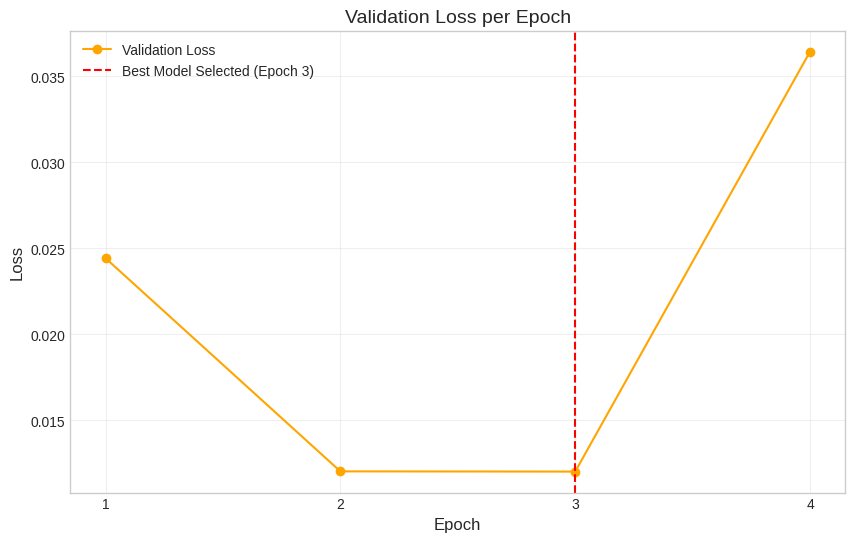

In [ ]:
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)

eval_df = log_df.dropna(subset=['eval_loss']).copy()

if not eval_df.empty:
    plt.figure(figsize=(10, 6))
    
    eval_df['epoch'] = pd.to_numeric(eval_df['epoch'])
    
    plt.plot(eval_df['epoch'], eval_df['eval_loss'], marker='o', linestyle='-', color='orange', label='Validation Loss')

    plt.title('Validation Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(eval_df['epoch'].unique())
    plt.grid(alpha=0.3)
    
    best_epoch_idx = eval_df['eval_loss'].idxmin()
    best_epoch_data = eval_df.loc[best_epoch_idx]
    best_epoch = best_epoch_data['epoch']
    
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model Selected (Epoch {int(best_epoch)})')
    plt.legend()
    plt.show()
else:
    print("No evaluation logs were found.")

## Validation Loss Analysis

Detailed visualization of validation loss during fine-tuning with enhanced axis labels and formatting. This plot provides clear insight into model convergence and the selection of the optimal checkpoint.


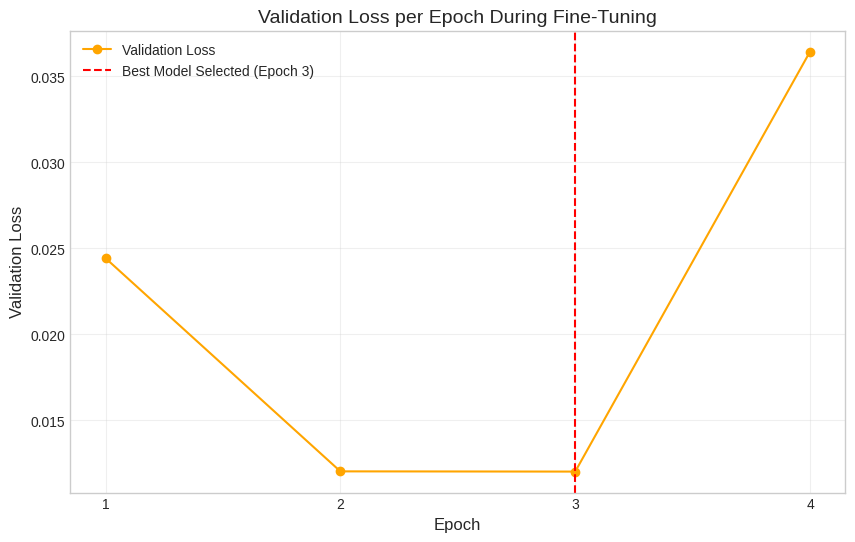

In [ ]:
log_history = trainer.state.log_history
log_df = pd.DataFrame(log_history)

eval_df = log_df.dropna(subset=['eval_loss']).copy()

if not eval_df.empty:
    plt.figure(figsize=(10, 6))
    
    eval_df['epoch'] = pd.to_numeric(eval_df['epoch'])
    
    plt.plot(eval_df['epoch'], eval_df['eval_loss'], marker='o', linestyle='-', color='orange', label='Validation Loss')

    plt.title('Validation Loss per Epoch During Fine-Tuning')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.xticks(eval_df['epoch'].unique())
    plt.grid(alpha=0.3)
    
    best_epoch_idx = eval_df['eval_loss'].idxmin()
    best_epoch_data = eval_df.loc[best_epoch_idx]
    best_epoch = best_epoch_data['epoch']
    
    plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Model Selected (Epoch {int(best_epoch)})')
    plt.legend()
    plt.show()
else:
    print("No evaluation logs were found.")

## Receiver Operating Characteristic (ROC) Curve

Generate the ROC curve to evaluate the model's ability to distinguish between real and fake news across different classification thresholds. The area under the curve (AUC) provides a single metric summarizing overall discriminative performance.


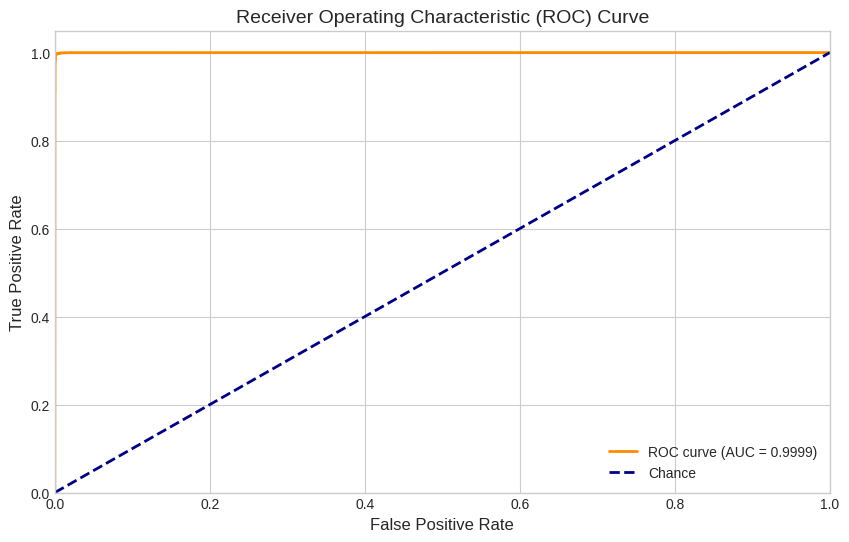

In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Feature Importance Analysis

Examine the importance of different embedding dimensions in the XGBoost classifier. This analysis identifies which features from the BERT embeddings contribute most significantly to the classification decision, providing insight into what the model learns.


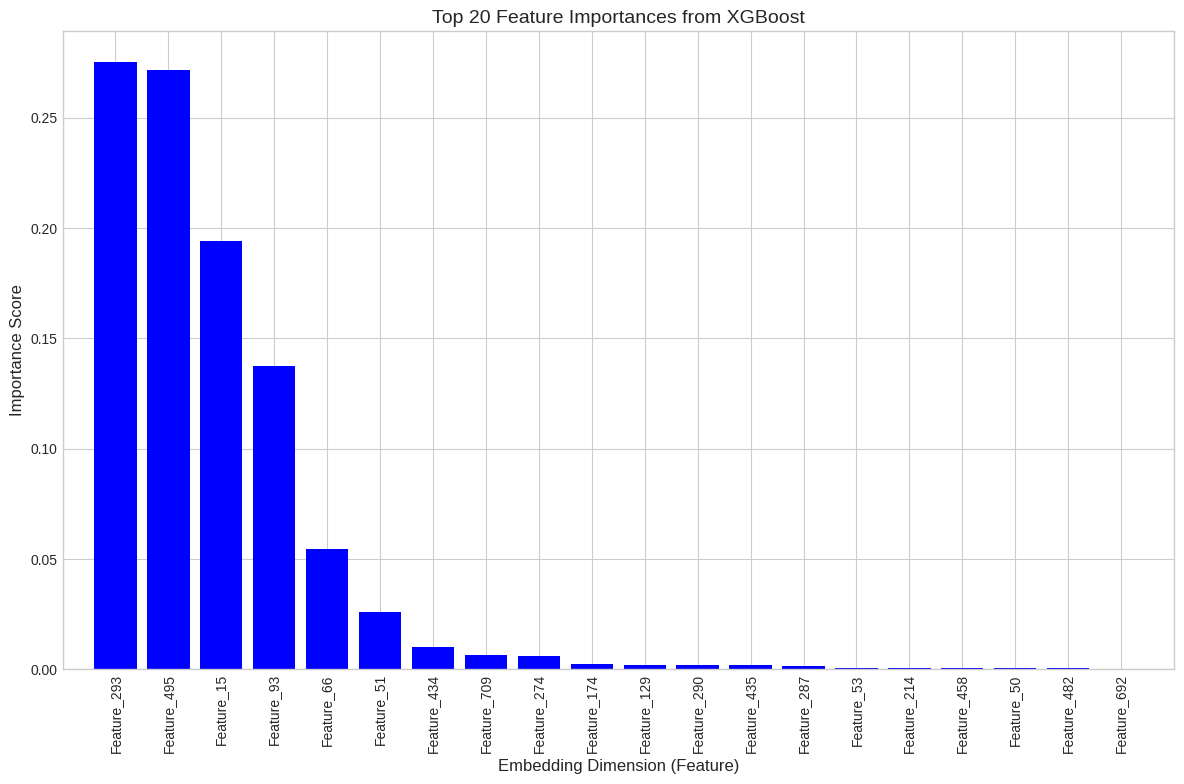

In [ ]:
importances = xgb_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 20

plt.figure(figsize=(12, 8))
plt.title(f'Top {top_n} Feature Importances from XGBoost')
plt.bar(range(top_n), importances[indices][:top_n], color="b", align="center")
plt.xticks(range(top_n), [f'Feature_{i}' for i in indices[:top_n]], rotation=90)
plt.xlim([-1, top_n])
plt.ylabel('Importance Score')
plt.xlabel('Embedding Dimension (Feature)')
plt.tight_layout()
plt.show()

## Precision-Recall Curve

Generate the precision-recall curve to evaluate model performance, particularly useful for imbalanced datasets. The average precision (AP) score summarizes the precision-recall relationship and provides an alternative to ROC-AUC for binary classification assessment.


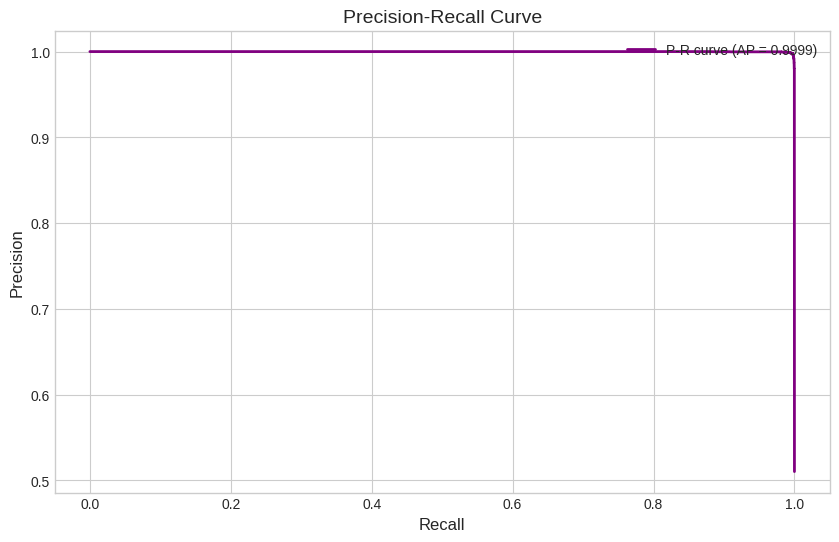

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

y_pred_proba = xgb_classifier.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='purple', lw=2, label=f'P-R curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

## Threshold Optimization

Analyze the relationship between classification threshold and model performance metrics. This analysis identifies the optimal decision threshold that maximizes F1-score, balancing precision and recall for the specific application requirements.


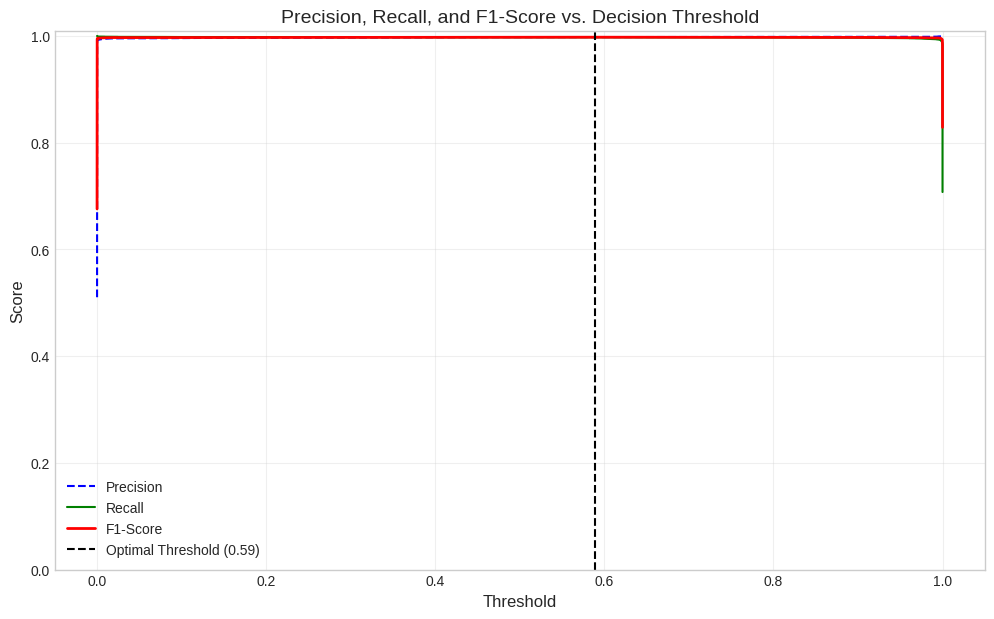

Optimal Threshold found at: 0.5892
At this threshold, F1-Score is: 0.9976


In [ ]:
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision_for_plot = precision[:-1]
recall_for_plot = recall[:-1]

f1_scores = 2 * (precision_for_plot * recall_for_plot) / (precision_for_plot + recall_for_plot)

plt.figure(figsize=(12, 7))
plt.plot(thresholds, precision_for_plot, 'b--', label='Precision')
plt.plot(thresholds, recall_for_plot, 'g-', label='Recall')
plt.plot(thresholds, f1_scores, 'r-', lw=2, label='F1-Score')

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
plt.axvline(x=optimal_threshold, color='black', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')

plt.title('Precision, Recall, and F1-Score vs. Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.ylim([0.0, 1.01])
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print(f"Optimal Threshold found at: {optimal_threshold:.4f}")
print(f"At this threshold, F1-Score is: {f1_scores[optimal_idx]:.4f}")

## Feature Correlation Analysis

Investigate the relationship between important embedding features and text characteristics. This analysis explores whether high-importance features correlate with observable text properties, providing insight into what semantic or structural information the model captures.


--- Probing Feature 512 ---
Pearson Correlation with Text Length: 0.0420
P-value: 0.0000
\nInterpretation: There is no significant linear correlation with text length.
This suggests the feature is likely capturing more abstract semantic or contextual information.


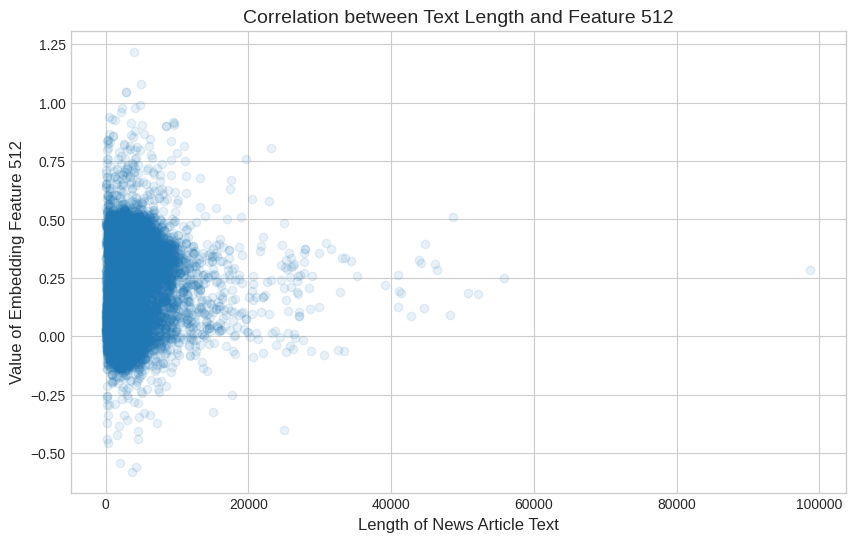

In [ ]:
import scipy.stats

feature_index = 512
important_feature_values = X_test[:, feature_index]

text_lengths = df_test['full_text'].str.len().values

correlation, p_value = scipy.stats.pearsonr(important_feature_values, text_lengths)

print(f"--- Probing Feature {feature_index} ---")
print(f"Pearson Correlation with Text Length: {correlation:.4f}")
print(f"P-value: {p_value:.4f}")

if abs(correlation) > 0.1 and p_value < 0.05:
    print("\\nInterpretation: There is a statistically significant, albeit potentially weak, correlation.")
    print(f"This suggests that Feature {feature_index} may be capturing some information related to the length or complexity of the text.")
else:
    print("\\nInterpretation: There is no significant linear correlation with text length.")
    print("This suggests the feature is likely capturing more abstract semantic or contextual information.")

plt.figure(figsize=(10, 6))
plt.scatter(text_lengths, important_feature_values, alpha=0.1)
plt.xlabel('Length of News Article Text')
plt.ylabel(f'Value of Embedding Feature {feature_index}')
plt.title(f'Correlation between Text Length and Feature {feature_index}')
plt.grid(True)
plt.show()